In [1]:
# Importing packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import json
import re
import cv2
import h5py
import sys
import copy
import random
from collections import deque

## defining different variables
data_dir = '../data/NIST19/'
img_size = 128
flatten_image_size = img_size**2
num_channels = 3
img_shape = (img_size,img_size,num_channels)
num_classes = 62 # 26 lower case alphabets, 26 upper case alphabets, 10 digits

# reading the maps
label_cls_name_map = {}
label_name_cls_map = {}
with open('label_cls_name.json', 'r') as f:
    label_cls_name_map = json.loads(f.read())
    
for k,v in label_cls_name_map.iteritems():
    label_name_cls_map[v] = k

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
xmin_range = range(40,46)
ymin_range = range(40,46)
xmax_range = range(80,86)
ymax_range = range(80,86)

dirs = os.listdir(data_dir)
#print dirs
all_annotations = []
for dir_ in dirs:
    try:
        if '.DS_Store' in dir_:
             continue
        class_name = chr(int(dir_,16))
        dir_path = os.path.join(os.path.join(data_dir, dir_), 'train_%s' % dir_)
        for file_ in os.listdir(dir_path):
            tuple_ = (file_, 128, 128, class_name, random.choice(xmin_range), random.choice(ymin_range),
                     random.choice(xmax_range), random.choice(ymax_range))
            all_annotations.append(tuple_)
    except Exception, err:
        print Exception, err

np.random.shuffle(all_annotations)
annotations_df = pd.DataFrame(all_annotations, columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin',
                                                        'xmax', 'ymax'])

train_length = int(len(annotations_df)*0.8)
train_annotations = annotations_df.iloc[:train_length]
train_annotations.to_csv('ocr_train_labels.csv', index=False)
test_annotations = annotations_df.iloc[train_length:]
test_annotations.to_csv('ocr_test_labels.csv', index=False)

annotations_df.to_csv('ocr_labels.csv', index=False)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
train_annotations

filename  width  height class  xmin  ymin  xmax  ymax
0       train_6c_08297.png    128     128     l    44    40    83    83
1       train_64_10533.png    128     128     d    41    42    85    84
2       train_33_03521.png    128     128     3    44    41    83    80
3       train_4f_25132.png    128     128     O    40    40    83    82
4       train_74_01125.png    128     128     t    41    41    80    80
5       train_35_01233.png    128     128     5    40    41    84    84
6       train_46_01556.png    128     128     F    43    40    81    83
7       train_32_11690.png    128     128     2    42    45    84    82
8       train_56_02648.png    128     128     V    43    44    81    84
9       train_78_00577.png    128     128     x    43    42    82    85
10      train_39_07764.png    128     128     9    42    42    83    81
11      train_71_00099.png    128     128     q    43    40    85    84
12      train_63_00367.png    128     128     c    40    43    81    85
13      train_32_04718.png    128     128     2    43    40    82    83
14      train_74_11356.png    128     128     t    41    40    84    84
15      train_50_01949.png    128     128     P    40    44    80    84
16      train_39_16697.png    128     128     9    45    45    84    80
17      train_6c_15795.png    128     128     l    43    44    81    80
18      train_36_16563.png    128     128     6    40    43    82    81
19      train_31_35840.png    128     128     1    42    45    84    82
20      train_45_00790.png    128     128     E    42    45    82    82
21      train_43_04495.png    128     128     C    41    44    80    82
22      train_38_21538.png    128     128     8    41    40    82    84
23      train_34_10178.png    128     128     4    43    44    80    84
24      train_37_26056.png    128     128     7    40    43    85    83
25      train_30_30034.png    128     128     0    41    42    82    83
26      train_39_09955.png    128     128     9    42    44    82    84
27      train_32_27717.png    128     128     2    42    42    84    80
28      train_49_11323.png    128     128     I    42    41    80    82
29      train_38_15363.png    128     128     8    45    43    83    80
...                    ...    ...     ...   ...   ...   ...   ...   ...
585304  train_38_08237.png    128     128     8    43    44    80    83
585305  train_53_12792.png    128     128     S    40    43    83    85
585306  train_34_26342.png    128     128     4    40    45    81    81
585307  train_74_15847.png    128     128     t    43    41    84    80
585308  train_34_11476.png    128     128     4    41    44    84    80
585309  train_53_01473.png    128     128     S    41    44    85    83
585310  train_53_09572.png    128     128     S    41    41    82    82
585311  train_30_20552.png    128     128     0    45    44    81    82
585312  train_65_04768.png    128     128     e    40    44    81    83
585313  train_57_02615.png    128     128     W    41    42    80    85
585314  train_6e_09299.png    128     128     n    41    44    81    83
585315  train_6e_05825.png    128     128     n    41    41    85    83
585316  train_36_26314.png    128     128     6    42    40    83    83
585317  train_38_10817.png    128     128     8    44    44    85    81
585318  train_32_20536.png    128     128     2    43    45    82    84
585319  train_6d_01638.png    128     128     m    45    45    82    80
585320  train_61_09158.png    128     128     a    44    40    84    83
585321  train_6a_00575.png    128     128     j    40    40    85    80
585322  train_45_01932.png    128     128     E    42    40    81    84
585323  train_30_26313.png    128     128     0    42    44    84    82
585324  train_65_25330.png    128     128     e    43    41    81    85
585325  train_54_02508.png    128     128     T    40    42    85    84
585326  train_31_11193.png    128     128     1    43    43    81    83
585327  train_64_02822.png    128     128     d    44    4

### Experiments

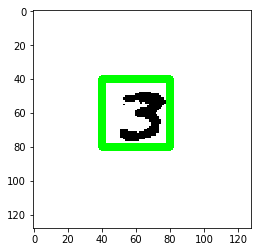

In [2]:
img = cv2.imread('../data/NIST19/33/train_33/train_33_00001.png')
cv2.rectangle(img,(xmin_range[0],ymin_range[0]),(xmax_range[0],ymax_range[0]),(0,255,0),3)
plt.imshow(img)